In [2]:
ddir = '/swot/SUM03/tmp/CESM/'

In [3]:
from keras.models import load_model


In [4]:
feature_cols = ['X', 'Y', 'Z',
                'X_e','X_w','X_n','X_s','X_ne','X_se','X_nw','X_sw',
                'Y_e','Y_w','Y_n','Y_s','Y_ne','Y_se','Y_nw','Y_sw',
                'Z_e','Z_w','Z_n','Z_s','Z_ne','Z_se','Z_nw','Z_sw',
                'TAUX','TAUY','SST','SSH',
                'SSH_e','SSH_w','SSH_n','SSH_s','SSH_ne','SSH_se','SSH_nw','SSH_sw']
model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(10, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse','accuracy'])

# show a summary of the data
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 40)                1600      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 20)                820       
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 10)                210       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 22        
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.load_weights('./model_checkpoints/weights_batch600_3layer_402010_1000d')

In [6]:
def threeD_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

def extract_vars_for_test(ds):
    shift_vars = ['SSH','XU','YU']
    coord_vars = ['XU','YU']

    shifts = {'_e': dict(nlon=-1),
              '_w': dict(nlon=1),
             '_n': dict(nlat=-1),
             '_s': dict(nlat=1),
             '_ne': dict(nlon=-1,nlat=-1),
             '_nw': dict(nlon=1,nlat=-1),
             '_se': dict(nlon=-1,nlat=1),
             '_sw': dict(nlon=1,nlat=1),}

    for suf, shift in shifts.items():
        for var in shift_vars:
            ds[var + suf] = ds[var].shift(**shift)
            
    suffixes = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
    for suf in suffixes:
        ds['X'+suf],ds['Y'+suf],ds['Z'+suf], = threeD_coords(ds['XU'+suf],ds['YU'+suf])
    return ds

def ds_to_eval_df(ds):
    targets=['U','V']
    feature_cols = ['X', 'Y', 'Z',
                'X_e','X_w','X_n','X_s','X_ne','X_se','X_nw','X_sw',
                'Y_e','Y_w','Y_n','Y_s','Y_ne','Y_se','Y_nw','Y_sw',
                'Z_e','Z_w','Z_n','Z_s','Z_ne','Z_se','Z_nw','Z_sw',
                'TAUX','TAUY','SST','SSH',
                'SSH_e','SSH_w','SSH_n','SSH_s','SSH_ne','SSH_se','SSH_nw','SSH_sw']


    df = ds.to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    y = df.loc[:, targets]
    

    return (X,y)

def ds_to_test_df(ds):
    feature_cols = ['X', 'Y', 'Z',
                'X_e','X_w','X_n','X_s','X_ne','X_se','X_nw','X_sw',
                'Y_e','Y_w','Y_n','Y_s','Y_ne','Y_se','Y_nw','Y_sw',
                'Z_e','Z_w','Z_n','Z_s','Z_ne','Z_se','Z_nw','Z_sw',
                'TAUX','TAUY','SST','SSH',
                'SSH_e','SSH_w','SSH_n','SSH_s','SSH_ne','SSH_se','SSH_nw','SSH_sw']


    df = ds.to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    

    return X

In [7]:
ds=xr.open_zarr(ddir+'hybrid_v5_rel04_BC5_ne120_t12_pop62', auto_chunk=False).chunk({'time': 1})
ds=ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})
ds_test = ds.isel(time=slice(1824,2189))

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


In [8]:
def geostrophic_vel(ds):

    d_eta_dx = 0.5*(ds.SSH_e - ds.SSH_w)/ds.DXT
    d_eta_dy = 0.5*(ds.SSH_n - ds.SSH_s)/ds.DYT

    Om = 7.2921e-5
    g = 9.81e2
    f = 2 * Om * np.sin(np.deg2rad(ds.YU))
    u_g = - g * d_eta_dy * f**-1
    v_g = g * d_eta_dx * f**-1
    return u_g.values, v_g.values

def ekman_vel(ds):
    rho_a = 1.25
    rho_w = 1027
    C_D = 2.6e-3
    om = 7.2921e-5
    f = 2 * om * np.sin(np.deg2rad(ds.YU.values))
    Az = 1.0e-1  
    f_NH = np.ma.masked_array(f, ~(f>0))
    f_SH = np.ma.masked_array(f, ~(f<0))
    tau_x = ds.TAUX.values
    tau_y = ds.TAUY.values
    u_e_N = (tau_x+tau_y)/(np.sqrt(2*Az*rho_w**2) * np.sqrt(np.abs(f_NH)))
    v_e_N = (-tau_x+tau_y)/(np.sqrt(2*Az*rho_w**2) * np.sqrt(np.abs(f_NH))) 
    u_e_S = (tau_x-tau_y)/(np.sqrt(2*Az*rho_w**2) * np.sqrt(np.abs(f_SH)))
    v_e_S = (tau_x+tau_y)/(np.sqrt(2*Az*rho_w**2) * np.sqrt(np.abs(f_SH)))
    
    u_e = np.ma.array(u_e_N.filled(0)+u_e_S.filled(0), mask=u_e_N.mask * u_e_S.mask)
    v_e = np.ma.array(v_e_N.filled(0)+v_e_S.filled(0), mask=v_e_N.mask * v_e_S.mask)
    
    return u_e, v_e 


def nn_vel(ds, model):
    pred = model.predict(ds_to_test_df(ds))
    mask_tot = ~(np.isnan(ds.SSH.values) | np.isnan(ds.SSH_e.values) | np.isnan(ds.SSH_w.values) |
                 np.isnan(ds.SSH_n.values) | np.isnan(ds.SSH_s.values)| np.isnan(ds.SSH_ne.values) |
                 np.isnan(ds.SSH_nw.values)| np.isnan(ds.SSH_se.values)| np.isnan(ds.SSH_sw.values) |
                 np.isnan(ds.U.values) | np.isnan(ds.V.values) | np.isnan(ds.SST.values) | 
                 np.isnan(ds.TAUX.values) | np.isnan(ds.TAUY.values) )
    
    u_pred_flat = pred[:,0]
    v_pred_flat = pred[:,1]
    assert mask_tot.sum() == len(u_pred_flat)
    assert mask_tot.sum() == len(v_pred_flat)    
    u_true = ds.U.values
    v_true = ds.V.values
    u_nn = np.full_like(u_true, np.nan)
    u_nn[mask_tot] = u_pred_flat
    v_nn = np.full_like(u_true, np.nan)
    v_nn[mask_tot] = v_pred_flat    
    mask_lat = ((ds.YU.values>5)|(ds.YU.values<-5))
    mask_geo = (mask_tot&mask_lat)
    return mask_tot, mask_lat, mask_geo, u_true, v_true, u_nn, v_nn


def masked_vel(u, mask):
    u_masked = np.ma.masked_array(u, ~mask)
    return u_masked

def get_latlon(ds):
    XU = ds.XU.values
    YU = ds.YU.values
    return XU, YU

In [9]:
from IPython.display import clear_output

In [10]:
import pandas as pd

In [13]:
vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V','DXT','DYT']
it = 176
times = pd.date_range('1951-01-01', periods=len(ds_test.time)+1)
ds_snap = extract_vars_for_test(ds_test.isel(time=it).reset_coords()[vars_wanted])
vels = {}
%time vels['mask_tot'], vels['mask_lat'], vels['mask_geo'], vels['u_t_um'], vels['v_t_um'], vels['u_n_um'], vels['v_n_um'] = nn_vel(ds_snap, model)
%time vels['u_g_um'], vels['v_g_um'] = geostrophic_vel(ds_snap)
%time vels['u_e_um'], vels['v_e_um']= ekman_vel(ds_snap)

CPU times: user 1min 46s, sys: 56.9 s, total: 2min 43s
Wall time: 2min 3s


/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)


CPU times: user 1.23 s, sys: 1.29 s, total: 2.52 s
Wall time: 1.85 s
CPU times: user 1.69 s, sys: 1.73 s, total: 3.42 s
Wall time: 3.41 s


In [14]:
vels['u_ge_um'] = vels['u_g_um']+np.sqrt(10)*vels['u_e_um']
vels['v_ge_um'] = vels['v_g_um']+np.sqrt(10)*vels['v_e_um']

vels['u_t'] = masked_vel(vels['u_t_um'],vels['mask_geo'])
vels['v_t'] = masked_vel(vels['v_t_um'],vels['mask_geo'])
vels['u_ge'] = masked_vel(vels['u_ge_um'],vels['mask_geo'])
vels['v_ge'] = masked_vel(vels['v_ge_um'],vels['mask_geo'])
vels['u_g'] = masked_vel(vels['u_g_um'],vels['mask_geo'])
vels['v_g'] = masked_vel(vels['v_g_um'],vels['mask_geo'])

In [15]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 16, 'axes.labelsize' : 13,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

lw=2
aph=.2

plt.rcParams['figure.figsize'] = (12.,6.)

In [16]:
errs = {}
errs['mae_u_n'] = np.nanmean((np.abs(vels['u_n_um']-vels['u_t_um'])))
errs['mae_v_n'] = np.nanmean((np.abs(vels['v_n_um']-vels['v_t_um'])))
errs['rmse_u_n'] = np.sqrt(np.nanmean((vels['u_n_um']-vels['u_t_um'])**2))
errs['rmse_v_n'] = np.sqrt(np.nanmean((vels['v_n_um']-vels['v_t_um'])**2))

errs['bias_u_n'] = np.nanmean(vels['u_n_um']) - np.nanmean(vels['u_t_um'])
errs['bias_v_n'] = np.nanmean(vels['v_n_um']) - np.nanmean(vels['v_t_um'])


errs['mae_u_ge'] = np.nanmean((np.abs(vels['u_ge']-vels['u_t'])))
errs['mae_v_ge'] = np.nanmean((np.abs(vels['v_ge']-vels['v_t'])))
errs['rmse_u_ge'] = np.sqrt(np.nanmean((vels['u_ge']-vels['u_t'])**2))
errs['rmse_v_ge'] = np.sqrt(np.nanmean((vels['v_ge']-vels['v_t'])**2))

errs['bias_u_ge'] = np.nanmean(vels['u_g']) - np.nanmean(vels['u_t'])
errs['bias_v_ge'] = np.nanmean(vels['v_g']) - np.nanmean(vels['v_t'])

errs['mae_u_g'] = np.nanmean((np.abs(vels['u_g']-vels['u_t'])))
errs['mae_v_g'] = np.nanmean((np.abs(vels['v_g']-vels['v_t'])))
errs['rmse_u_g'] = np.sqrt(np.nanmean((vels['u_g']-vels['u_t'])**2))
errs['rmse_v_g'] = np.sqrt(np.nanmean((vels['v_g']-vels['v_t'])**2))

errs['bias_u_g'] = np.nanmean(vels['u_g']) - np.nanmean(vels['u_t'])
errs['bias_v_g'] = np.nanmean(vels['v_g']) - np.nanmean(vels['v_t'])



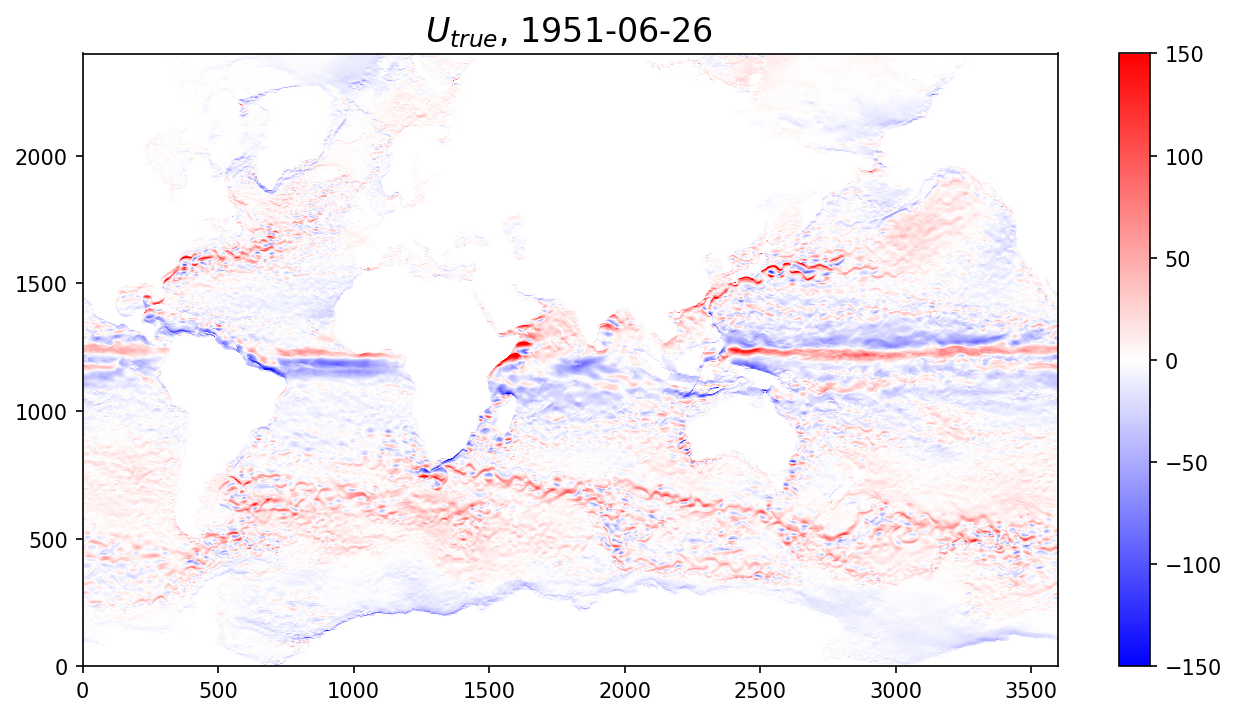

In [17]:
fig = plt.figure(figsize=(9,5),dpi=150)
plt.pcolormesh(vels['u_t_um'],vmin=-150,vmax=150,cmap='bwr',rasterized=True );
plt.colorbar()
plt.title(r'$U_{true}$, 1951-06-26 ');
plt.tight_layout()
fig.savefig('Figs_NN/U_true_globe_600batch_176.png')
fig.savefig('Figs_NN/U_true_globe_600batch_176.pdf', dpi=150)

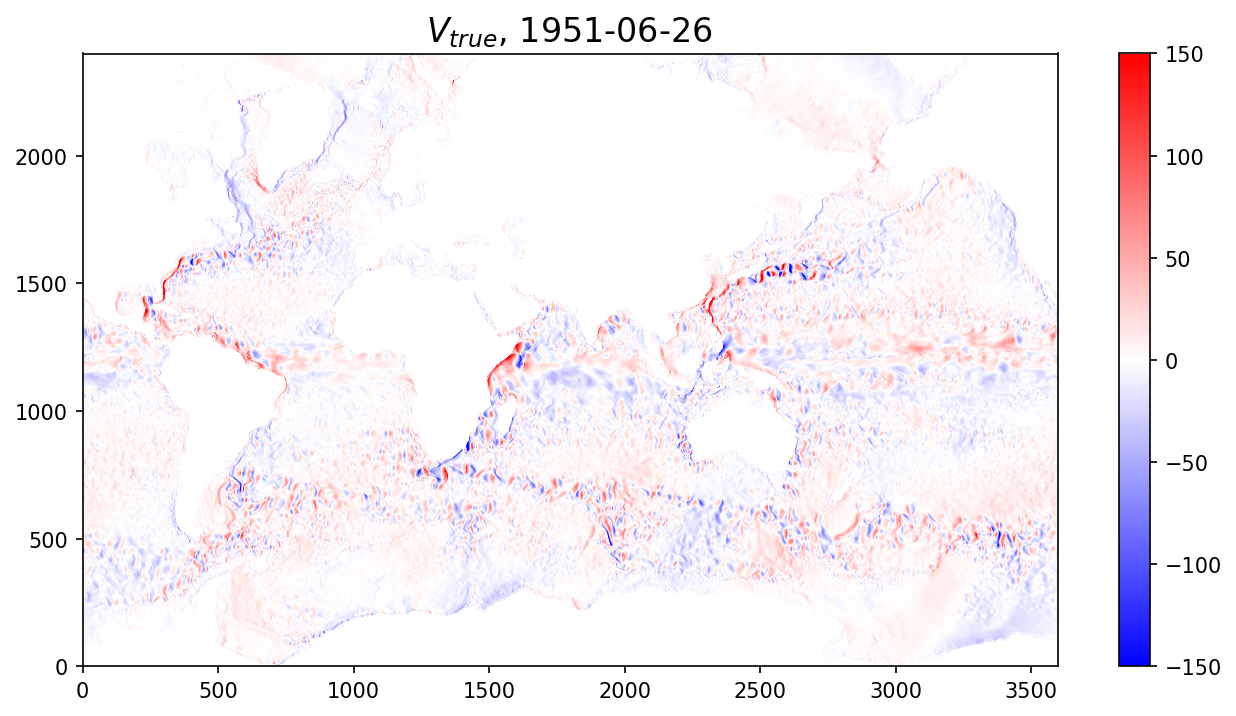

In [18]:
fig = plt.figure(figsize=(9,5),dpi=150)
plt.pcolormesh(vels['v_t_um'],vmin=-150,vmax=150,cmap='bwr',rasterized=True );
plt.colorbar()
plt.title(r'$V_{true}$, 1951-06-26 ');
plt.tight_layout()
fig.savefig('Figs_NN/V_true_globe_600batch_176.png')
fig.savefig('Figs_NN/V_true_globe_600batch_176.pdf', dpi=150)

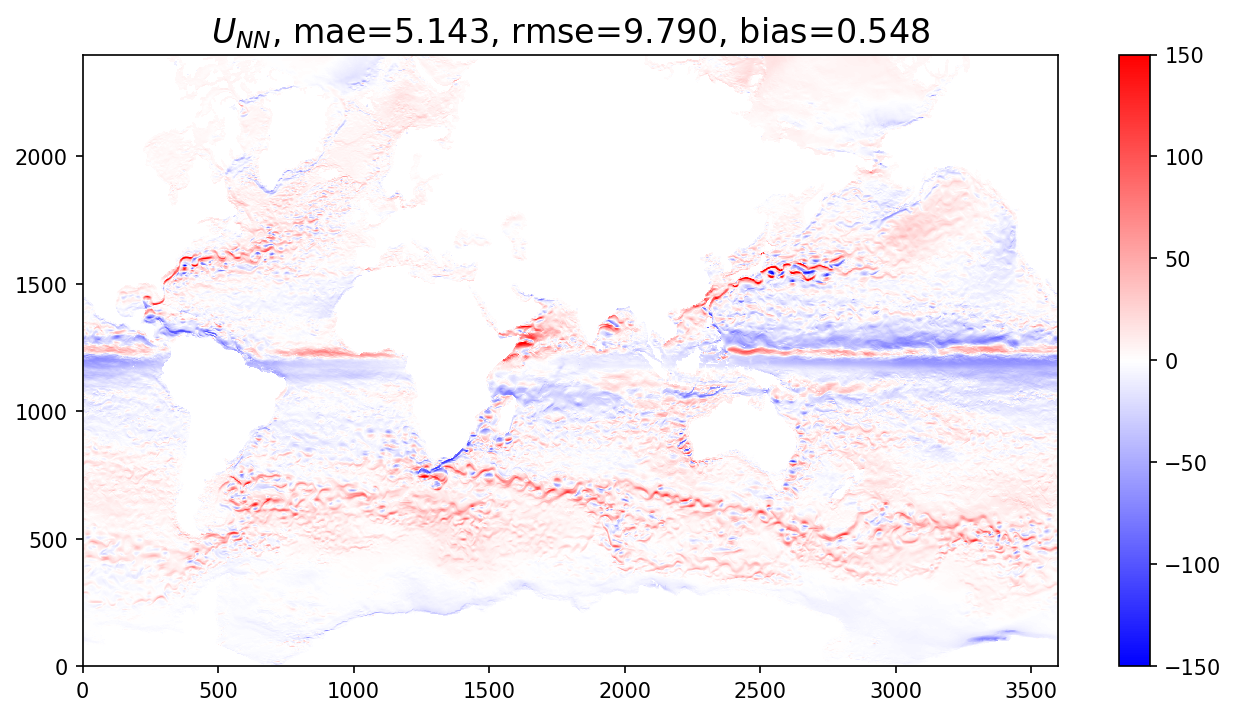

In [19]:
fig = plt.figure(figsize=(9,5),dpi=150)
plt.pcolormesh(vels['u_n_um'],vmin=-150,vmax=150,cmap='bwr',rasterized=True );
plt.colorbar()
plt.title(r'$U_{NN}$, mae=%1.3f, rmse=%1.3f, bias=%1.3f'%(errs['mae_u_n'],errs['rmse_u_n'],errs['bias_u_n']) );
plt.tight_layout()
fig.savefig('Figs_NN/U_NN_globe_600batch_176.png')
fig.savefig('Figs_NN/U_NN_globe_600batch_176.pdf', dpi=150)


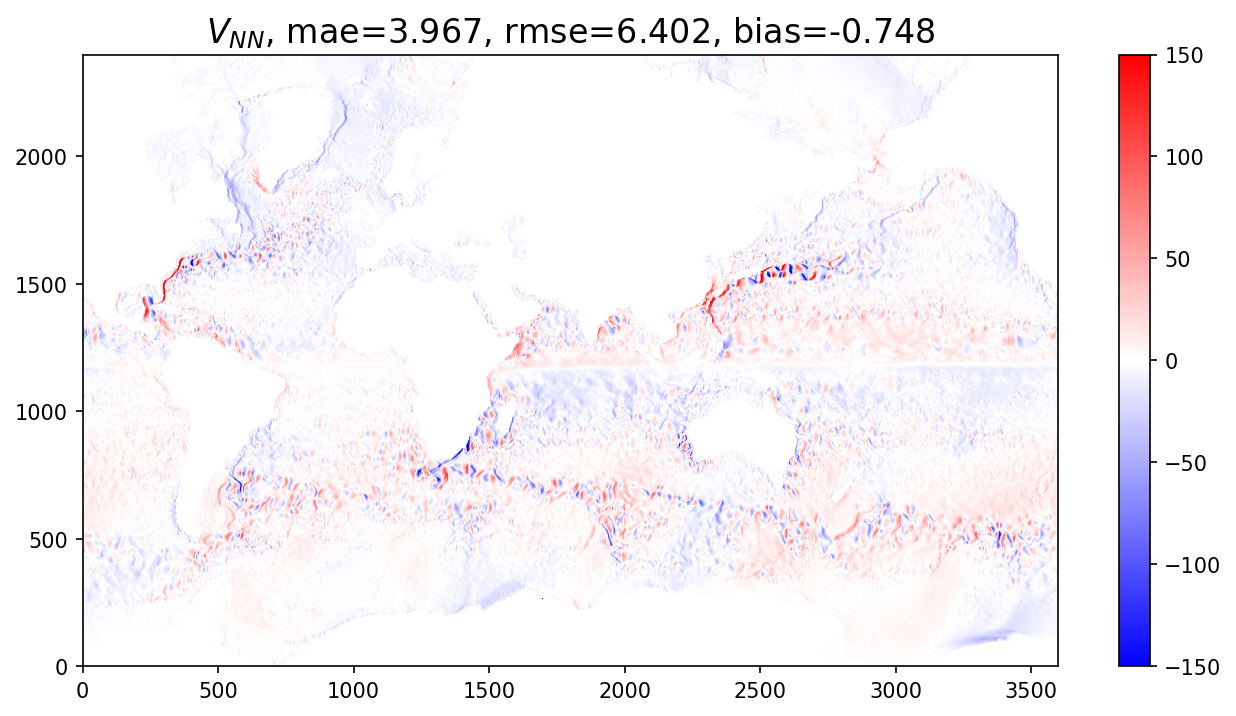

In [20]:
fig = plt.figure(figsize=(9,5),dpi=150)
plt.pcolormesh(vels['v_n_um'],vmin=-150,vmax=150,cmap='bwr',rasterized=True );
plt.colorbar()
plt.title(r'$V_{NN}$, mae=%1.3f, rmse=%1.3f, bias=%1.3f'%(errs['mae_v_n'],errs['rmse_v_n'],errs['bias_v_n']) );
plt.tight_layout()
fig.savefig('Figs_NN/V_NN_globe_600batch_176.png')
fig.savefig('Figs_NN/V_NN_globe_600batch_176.pdf', dpi=150)


In [11]:
outdir = '/swot/SUM02/as4479/POP_nn600batch_predictions/'

In [ ]:
for it in range(len(ds_test.time)):
    clear_output(wait=True)

    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V','DXT','DYT']

    times = pd.date_range('1951-01-01', periods=len(ds_test.time)+1)
    ds_snap = extract_vars_for_test(ds_test.isel(time=it).reset_coords()[vars_wanted])
    vels = {}
    %time vels['mask_tot'], vels['mask_lat'], vels['mask_geo'], vels['u_t_um'], vels['v_t_um'], vels['u_n_um'], vels['v_n_um'] = nn_vel(ds_snap, model)
    %time vels['u_g_um'], vels['v_g_um'] = geostrophic_vel(ds_snap)
    %time vels['u_e_um'], vels['v_e_um']= ekman_vel(ds_snap)

    varlist = ['u','v']
    suffix1 = ['_g','_e','_n','_t']
    suffix2 = '_um'
    
    for var in varlist:
        for suf in suffix1:
            vels[var+suf] = masked_vel(vels[var+suf+suffix2],vels['mask_geo'])

    vels['u_ge'] = vels['u_g'] + vels['u_e']
    vels['v_ge'] = vels['v_g'] + vels['v_e']
    vels['XU'],vels['YU'] = get_latlon(ds_snap)

    ds_new = xr.Dataset()
    for key in vels.keys():
        ds_new[key] = xr.DataArray(vels[key][np.newaxis,:],
                                    dims=['time','nlat', 'nlon'], 
                                    coords={'time':times[it:it+1], 'nlon':ds_snap.nlon, 'nlat': ds_snap.nlat} )
    ds_new.to_netcdf(outdir+'POP_global_600batch_3layer402010nn_pred_%05d.nc'%it)
    print('Time=%05d'%it)

CPU times: user 1min 29s, sys: 43.5 s, total: 2min 13s
Wall time: 1min 43s


/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)


CPU times: user 1.25 s, sys: 1.37 s, total: 2.63 s
Wall time: 1.87 s
CPU times: user 1.56 s, sys: 1.49 s, total: 3.05 s
Wall time: 3.04 s
Time=00059
